In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.model_selection import ParameterGrid

from recsys4daos.models import NLPSimilarity
from recsys4daos.utils import Timer
from recsys4daos.datasets import to_microsoft
from recsys4daos.evaluation import calculate_all_metrics
from recsys4daos.model_selection import cvtt_open, explore_hparams

import paths

import seaborn as sns
sns.set_theme()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/home/daviddavo/recsys4daos/.direnv/python-3.11/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Parameters

In [2]:
# Dataset config
ORG_NAME = 'Decentraland'

# Evaluation
K_RECOMMENDATIONS: list[int] = [1,3,5,10,15,100]
SPLITS_FREQ: str = 'W-THU' # split weekly
SPLITS_NORMALIZE = True # Wether or not to move everything to 00:00
LAST_FOLDS = 10 # Use just last 10 splits
LAST_FOLD_DATE_STR: str = None

# Search space config
WINDOW_SIZES = ['7d', '14d', '21d', '30d', '60d', '90d', '10YE']
PLN_MODEL_NAMES = [
    'all-mpnet-base-v2', # The one used in sbert's examples
    'all-distilroberta-v1',
    'all-MiniLM-L12-v2',
    'all-MiniLM-L6-v2',
]

OPTIM_METRIC = 'map@10'

In [3]:
# Parameters
EXECUTION_ID = "2024-09-04T10:00"
ORG_NAME = "Frax"
SPLITS_FREQ = "5d"
LAST_FOLDS = 10
SPLITS_NORMALIZE = True
LAST_FOLD_DATE_STR = "2022-05-26"


In [4]:
EMBEDDINGS_CACHE = Path(paths.DEFAULT_CACHE_PATH) / 'pln-embeddings'

# Load the dataset

In [5]:
dfp = paths.load_proposals(ORG_NAME, text=True)
dfv = paths.load_votes(ORG_NAME)

print(dfp.info())
print(dfv.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359 entries, 0 to 358
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 359 non-null    object        
 1   author             359 non-null    object        
 2   date               359 non-null    datetime64[us]
 3   start              359 non-null    datetime64[us]
 4   end                359 non-null    datetime64[us]
 5   platform_proposal  359 non-null    object        
 6   title              359 non-null    object        
 7   description        359 non-null    object        
dtypes: datetime64[us](3), object(5)
memory usage: 22.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10184 entries, 0 to 10183
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        10184 non-null  object        
 1   proposal  10184 non-null  obje

In [6]:
df = to_microsoft(dfv)
df

,userID,itemID,timestamp,rating
0,0xc049dd035e0171379fc608cef3260c1e6bceaaef,35601a29-c21f-5c8b-8176-a61cd9dc7d84,2021-02-10 22:33:15,1
1,0x3ce00d8677a44779fab24d897bfcafb4b96c9204,35601a29-c21f-5c8b-8176-a61cd9dc7d84,2021-02-11 03:36:59,1
2,0xb3eb02ac81c49a20290eeb7e8a5f66da6fb1e3f0,35601a29-c21f-5c8b-8176-a61cd9dc7d84,2021-02-11 08:01:51,1
3,0x09d57f361f794d150c04443a7b6e369120dc2bea,35601a29-c21f-5c8b-8176-a61cd9dc7d84,2021-02-11 08:02:27,1
4,0x3c28c42b24b7909c8292920929f083f60c4997a6,35601a29-c21f-5c8b-8176-a61cd9dc7d84,2021-02-11 11:51:03,1
...,...,...,...,...
10179,0xb1417c3a3d10102e57bc123827b942fb60dca1e4,1c6c0bf0-f2b4-5998-ab91-76e35a86a0c5,2023-07-17 12:59:55,1
10180,0x724061efdfef4a421e8be05133ad24922d07b5bf,57e9175b-41a6-5aaf-bd1c-6a13093b5419,2023-07-17 22:49:06,1
10181,0x337844866ce1f51be8eb9f3a4882b5cb891edba5,57e9175b-41a6-5aaf-bd1c-6a13093b5419,2023-07-19 00:02:32,1
10182,0x4b47052498d469ac9521606a67d6f02afeb0985a,57e9175b-41a6-5aaf-bd1c-6a13093b5419,2023-07-19 12:31:54,1


## Split in folds

In [7]:
all_folds = { f.end:f for f in cvtt_open(
    df, SPLITS_FREQ, dfp.reset_index(), remove_not_in_train_col='userID', last_fold=LAST_FOLD_DATE_STR,
)}
last_folds_idx = list(all_folds.keys())[-LAST_FOLDS:]
last_folds_idx

[Timestamp('2022-04-11 00:00:00'),
 Timestamp('2022-04-16 00:00:00'),
 Timestamp('2022-04-21 00:00:00'),
 Timestamp('2022-04-26 00:00:00'),
 Timestamp('2022-05-01 00:00:00'),
 Timestamp('2022-05-06 00:00:00'),
 Timestamp('2022-05-11 00:00:00'),
 Timestamp('2022-05-16 00:00:00'),
 Timestamp('2022-05-21 00:00:00'),
 Timestamp('2022-05-26 00:00:00')]

# Similarity PLN

In [8]:
def testHParamsPLNSimilarity(fold, window_size, model_name):
    f = all_folds[fold]
    
    model = NLPSimilarity(dfp, EMBEDDINGS_CACHE, model_name=model_name)

    offset = pd.tseries.frequencies.to_offset(window_size)
    train = f.train[f.train['timestamp'] > (f.end - offset)]

    with Timer() as t_fit:
        model.fit(train)

    with Timer() as t_rec:
        # Truncate the top_k
        top_k = max(K_RECOMMENDATIONS)
        users = np.intersect1d(f.test['userID'].unique(), train['userID'].unique())
        recs = model.recommend_k_items(users, top_k=min(len(f.open_proposals), top_k), recommend_from=f.open_proposals)
    
    return {
        'time_train': t_fit.time,
        'time_rec': t_rec.time,
        'rec_users': len(users),
        **calculate_all_metrics(f.test, recs, K_RECOMMENDATIONS),
    }

# testHParamsPLNSimilarity(last_folds_idx[0], '14D', PLN_MODEL_NAMES[0])

In [9]:
# Populate the cache of embeddings for each model
from recsys4daos.models.nlp import NLPModel

for m in PLN_MODEL_NAMES:
    NLPModel(dfp, EMBEDDINGS_CACHE, model_name=m).fit()

In [10]:
results = explore_hparams(
    testHParamsPLNSimilarity,
    ParameterGrid({
        'fold': last_folds_idx,
        'model_name': PLN_MODEL_NAMES,
        'window_size': WINDOW_SIZES,
    }),
    paths.hparams_progress('pln-similarity', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE),
)
mdf = pd.DataFrame(results)
mdf

  0%|          | 0/280 [00:00<?, ?it/s]

[2024-09-16T14:14:17.591667] Saving checkpoint at ../.cache/Frax/hparams-pln-similarity_5d_normalize.pkl


[2024-09-16T14:15:18.480701] Saving checkpoint at ../.cache/Frax/hparams-pln-similarity_5d_normalize.pkl


[2024-09-16T14:16:19.699272] Saving checkpoint at ../.cache/Frax/hparams-pln-similarity_5d_normalize.pkl


[2024-09-16T14:17:20.541842] Saving checkpoint at ../.cache/Frax/hparams-pln-similarity_5d_normalize.pkl


[2024-09-16T14:18:20.907976] Saving checkpoint at ../.cache/Frax/hparams-pln-similarity_5d_normalize.pkl


[2024-09-16T14:19:21.138899] Saving checkpoint at ../.cache/Frax/hparams-pln-similarity_5d_normalize.pkl


[2024-09-16T14:20:22.540809] Saving checkpoint at ../.cache/Frax/hparams-pln-similarity_5d_normalize.pkl


,fold,model_name,window_size,time_train,time_rec,rec_users,precision@1,precision@3,precision@5,precision@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
0,2022-04-11,all-mpnet-base-v2,7d,0.090576,0.000810,0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.069495
1,2022-04-11,all-mpnet-base-v2,14d,0.250640,0.001146,1,1.0,0.333333,0.2,0.1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.114963
2,2022-04-11,all-mpnet-base-v2,21d,0.090867,0.001160,1,1.0,0.333333,0.2,0.1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.115935
3,2022-04-11,all-mpnet-base-v2,30d,0.256455,0.001106,1,1.0,0.333333,0.2,0.1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.115809
4,2022-04-11,all-mpnet-base-v2,60d,0.104773,0.001166,1,1.0,0.333333,0.2,0.1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.114420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,2022-05-26,all-MiniLM-L6-v2,21d,0.082279,0.001223,18,1.0,0.333333,0.2,0.1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.121375
276,2022-05-26,all-MiniLM-L6-v2,30d,0.246259,0.001165,19,1.0,0.333333,0.2,0.1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.122992
277,2022-05-26,all-MiniLM-L6-v2,60d,0.272304,0.001217,19,1.0,0.333333,0.2,0.1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.122068
278,2022-05-26,all-MiniLM-L6-v2,90d,0.116378,0.001286,19,1.0,0.333333,0.2,0.1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.121880


<Axes: xlabel='window_size', ylabel='map@10'>

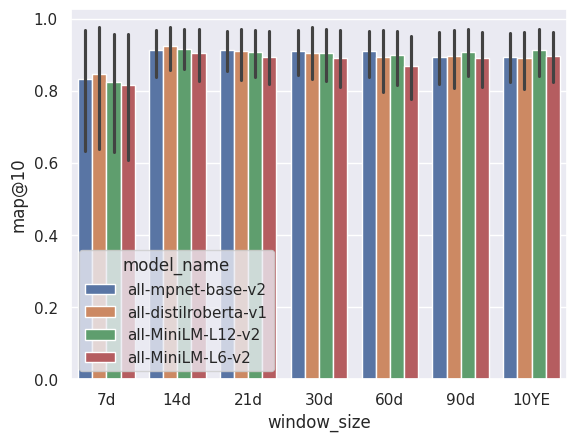

In [11]:
sns.barplot(mdf, x='window_size', y=OPTIM_METRIC, hue='model_name')

## Best overall hparams

In [12]:
display_columns = ['time_train'] + [ c for c in mdf.columns if c.endswith('@5') or c.endswith('@10') or c.endswith('@100') ]
hparam_cols = ['window_size', 'model_name']
overall_hparams = mdf[mdf['fold'] > last_folds_idx[0]].groupby(hparam_cols).mean().sort_values(OPTIM_METRIC, ascending=False)
overall_hparams[display_columns]

time_train  precision@5  precision@10  \
window_size model_name                                                    
7d          all-distilroberta-v1    0.144850     0.254292      0.127146   
            all-mpnet-base-v2       0.167512     0.254292      0.127146   
            all-MiniLM-L12-v2       0.150571     0.254292      0.127146   
14d         all-distilroberta-v1    0.212144     0.270137      0.135068   
            all-MiniLM-L12-v2       0.173120     0.270137      0.135068   
7d          all-MiniLM-L6-v2        0.151742     0.254292      0.127146   
21d         all-mpnet-base-v2       0.179969     0.263061      0.131531   
10YE        all-MiniLM-L12-v2       0.326786     0.252231      0.126116   
14d         all-mpnet-base-v2       0.192480     0.270137      0.135068   
30d         all-mpnet-base-v2       0.188162     0.257579      0.128790   
21d         all-distilroberta-v1    0.159814     0.263061      0.131531   
60d         all-mpnet-base-v2       0.219500     0.253632      0.126816   
90d         all-MiniLM-L12-v2       0.188908     0.251691      0.125845   
21d         all-MiniLM-L12-v2       0.180006     0.263061      0.131531   
30d         all-distilroberta-v1    0.231305     0.257579      0.128790   
14d         all-MiniLM-L6-v2        0.173489     0.270137      0.135068   
30d         all-MiniLM-L12-v2       0.204794     0.257579      0.128790   
60d         all-MiniLM-L12-v2       0.214240     0.253632      0.126816   
10YE        all-MiniLM-L6-v2        0.329192     0.252231      0.126116   
90d         all-distilroberta-v1    0.209702     0.251691      0.125845   
21d         all-MiniLM-L6-v2        0.161714     0.263061      0.131531   
10YE        all-mpnet-base-v2       0.390229     0.252231      0.126116   
90d         all-mpnet-base-v2       0.188905     0.251691      0.125845   
60d         all-distilroberta-v1    0.228714     0.253632      0.126816   
90d         all-MiniLM-L6-v2        0.189619     0.251691      0.125845   
30d         all-MiniLM-L6-v2        0.202264     0.257579      0.128790   
10YE        all-distilroberta-v1    0.353371     0.252231      0.126116   
60d         all-MiniLM-L6-v2        0.214677     0.253632      0.126816   

                                  precision@100    ndcg@5   ndcg@10  ndcg@100  \
window_size model_name                                                          
7d          all-distilroberta-v1       0.012715  0.451876  0.451876  0.451876   
            all-mpnet-base-v2          0.012715  0.448934  0.448934  0.448934   
            all-MiniLM-L12-v2          0.012715  0.441945  0.441945  0.441945   
14d         all-distilroberta-v1       0.013507  0.638945  0.638945  0.638945   
            all-MiniLM-L12-v2          0.013507  0.634347  0.634347  0.634347   
7d          all-MiniLM-L6-v2           0.012715  0.440237  0.440237  0.440237   
21d         all-mpnet-base-v2          0.013153  0.702705  0.702705  0.702705   
10YE        all-MiniLM-L12-v2          0.012612  0.929644  0.929644  0.929644   
14d         all-mpnet-base-v2          0.013507  0.633190  0.633190  0.633190   
30d         all-mpnet-base-v2          0.012879  0.818621  0.818621  0.818621   
21d         all-distilroberta-v1       0.013153  0.702025  0.702025  0.702025   
60d         all-mpnet-base-v2          0.012682  0.898305  0.898305  0.898305   
90d         all-MiniLM-L12-v2          0.012585  0.909872  0.909872  0.909872   
21d         all-MiniLM-L12-v2          0.013153  0.700325  0.700325  0.700325   
30d         all-distilroberta-v1       0.012879  0.815297  0.815297  0.815297   
14d         all-MiniLM-L6-v2           0.013507  0.628690  0.628690  0.628690   
30d         all-MiniLM-L12-v2          0.012879  0.814642  0.814642  0.814642   
60d         all-MiniLM-L12-v2          0.012682  0.889621  0.889621  0.889621   
10YE        all-MiniLM-L6-v2           0.012612  0.916117  0.916117  0.916117   
90d         all-distilroberta-v1       0.012585  0.898747  0.898747  0.898747   
2

In [13]:
best_avg_hparams = mdf.set_index(hparam_cols).loc[overall_hparams.iloc[0].name].reset_index().set_index(['fold', *hparam_cols])
paths.save_model_results(best_avg_hparams, 'plnsim-best-avg', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
best_avg_hparams

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Frax/models/plnsim-best-avg_5d_normalize.parquet


/tmp/ipykernel_1353906/971293119.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  best_avg_hparams = mdf.set_index(hparam_cols).loc[overall_hparams.iloc[0].name].reset_index().set_index(['fold', *hparam_cols])


,,,time_train,time_rec,rec_users,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
fold,window_size,model_name,,,,,,,,,,,,,,,,,,,,,
2022-04-11,7d,all-distilroberta-v1,0.086390,0.000330,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.068983
2022-04-16,7d,all-distilroberta-v1,0.253909,0.001366,5,0.800000,0.533333,0.360000,0.180000,0.120000,0.018000,0.166667,...,1.0,1.0,1.0,0.625000,0.8,0.8,0.8,0.8,0.8,0.125566
2022-04-21,7d,all-distilroberta-v1,0.092235,0.001151,7,1.000000,0.333333,0.200000,0.100000,0.066667,0.010000,0.700000,...,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,0.121529
2022-04-26,7d,all-distilroberta-v1,0.093872,0.001296,26,0.923077,0.371795,0.223077,0.111538,0.074359,0.011154,0.585366,...,1.0,1.0,1.0,0.937500,1.0,1.0,1.0,1.0,1.0,0.125607
2022-05-01,7d,all-distilroberta-v1,0.088971,0.001326,18,0.944444,0.425926,0.255556,0.127778,0.085185,0.012778,0.531250,...,1.0,1.0,1.0,0.852941,1.0,1.0,1.0,1.0,1.0,0.134393
2022-05-06,7d,all-distilroberta-v1,0.089612,0.001225,4,1.000000,0.583333,0.350000,0.175000,0.116667,0.017500,0.222222,...,1.0,1.0,1.0,0.625000,1.0,1.0,1.0,1.0,1.0,0.121698
2022-05-11,7d,all-distilroberta-v1,0.253545,0.001100,6,0.666667,0.500000,0.300000,0.150000,0.100000,0.015000,0.285714,...,1.0,1.0,1.0,0.625000,1.0,1.0,1.0,1.0,1.0,0.123474
2022-05-16,7d,all-distilroberta-v1,0.258909,0.001093,1,1.000000,0.333333,0.200000,0.100000,0.066667,0.010000,0.250000,...,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,0.119286
2022-05-21,7d,all-distilroberta-v1,0.087975,0.001291,18,0.722222,0.333333,0.200000,0.100000,0.066667,0.010000,0.500000,...,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,0.125888


## best hparams by fold

In [14]:
print("Best hyperparams by fold", OPTIM_METRIC)
best_hparams = mdf.sort_values(OPTIM_METRIC,ascending=False).drop_duplicates(['fold'], keep='first').sort_values('fold').set_index(['fold', 'model_name', 'window_size'])
paths.save_model_results(best_hparams, 'plnsim-best-val', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
best_hparams[display_columns]

Best hyperparams by fold map@10
Saved dataframe into /home/daviddavo/recsys4daos/data/output/Frax/models/plnsim-best-val_5d_normalize.parquet


,,,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
fold,model_name,window_size,,,,,,,,,,,,,,,,
2022-04-11,all-mpnet-base-v2,14d,0.250640,0.200000,0.100000,0.010000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
2022-04-16,all-distilroberta-v1,7d,0.253909,0.360000,0.180000,0.018000,0.190443,0.190443,0.190443,0.866667,0.866667,0.866667,1.0,1.0,1.0,0.8,0.8,0.8
2022-04-21,all-MiniLM-L12-v2,60d,0.261262,0.200000,0.100000,0.010000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
2022-04-26,all-distilroberta-v1,7d,0.093872,0.223077,0.111538,0.011154,0.616143,0.616143,0.616143,0.961538,0.961538,0.961538,1.0,1.0,1.0,1.0,1.0,1.0
2022-05-01,all-MiniLM-L12-v2,7d,0.256787,0.255556,0.127778,0.012778,0.550967,0.550967,0.550967,0.972222,0.972222,0.972222,1.0,1.0,1.0,1.0,1.0,1.0
2022-05-06,all-mpnet-base-v2,7d,0.275629,0.350000,0.175000,0.017500,0.222222,0.222222,0.222222,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
2022-05-11,all-MiniLM-L12-v2,10YE,0.225009,0.257143,0.128571,0.012857,0.973638,0.973638,0.973638,0.964286,0.964286,0.964286,1.0,1.0,1.0,1.0,1.0,1.0
2022-05-16,all-mpnet-base-v2,14d,0.099444,0.200000,0.100000,0.010000,0.500000,0.500000,0.500000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
2022-05-21,all-mpnet-base-v2,7d,0.088480,0.200000,0.100000,0.010000,0.635528,0.635528,0.635528,0.888889,0.888889,0.888889,1.0,1.0,1.0,1.0,1.0,1.0


In [15]:
best_hparams.describe()[display_columns]

,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.0,10.0,10.000000,10.000000,10.000000
mean,0.193942,0.244578,0.122289,0.012229,0.663894,0.663894,0.663894,0.965360,0.965360,0.965360,1.0,1.0,1.0,0.980000,0.980000,0.980000
std,0.079262,0.062461,0.031231,0.003123,0.310136,0.310136,0.310136,0.049047,0.049047,0.049047,0.0,0.0,0.0,0.063246,0.063246,0.063246
min,0.088480,0.200000,0.100000,0.010000,0.190443,0.190443,0.190443,0.866667,0.866667,0.866667,1.0,1.0,1.0,0.800000,0.800000,0.800000
25%,0.108181,0.200000,0.100000,0.010000,0.512742,0.512742,0.512742,0.962225,0.962225,0.962225,1.0,1.0,1.0,1.000000,1.000000,1.000000
50%,0.237824,0.211538,0.105769,0.010577,0.625835,0.625835,0.625835,0.986111,0.986111,0.986111,1.0,1.0,1.0,1.000000,1.000000,1.000000
75%,0.256067,0.256746,0.128373,0.012837,0.967728,0.967728,0.967728,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000
max,0.275629,0.360000,0.180000,0.018000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000


### Results of using best hparams on next fold

In [16]:
next_hparams_idx = best_hparams.index.to_frame(False)
next_hparams_idx['fold'] = next_hparams_idx['fold'].shift(-1)
next_hparams_idx = next_hparams_idx.dropna()
assert len(next_hparams_idx) == len(best_hparams)-1
next_hparams = mdf.set_index(['fold', 'model_name', 'window_size']).loc[pd.MultiIndex.from_frame(next_hparams_idx)]
paths.save_model_results(next_hparams, 'plnsim-best-test', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
next_hparams[display_columns]

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Frax/models/plnsim-best-test_5d_normalize.parquet


,,,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
fold,model_name,window_size,,,,,,,,,,,,,,,,
2022-04-16,all-mpnet-base-v2,14d,0.089348,0.490909,0.245455,0.024545,0.349360,0.349360,0.349360,0.667424,0.667424,0.667424,1.0,1.0,1.0,0.648148,0.648148,0.648148
2022-04-21,all-distilroberta-v1,7d,0.092235,0.200000,0.100000,0.010000,0.700000,0.700000,0.700000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000
2022-04-26,all-MiniLM-L12-v2,60d,0.102351,0.243243,0.121622,0.012162,0.767413,0.767413,0.767413,0.797297,0.797297,0.797297,1.0,1.0,1.0,1.000000,1.000000,1.000000
2022-05-01,all-distilroberta-v1,7d,0.088971,0.255556,0.127778,0.012778,0.550967,0.550967,0.550967,0.972222,0.972222,0.972222,1.0,1.0,1.0,1.000000,1.000000,1.000000
2022-05-06,all-MiniLM-L12-v2,7d,0.074778,0.350000,0.175000,0.017500,0.222222,0.222222,0.222222,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000
2022-05-11,all-mpnet-base-v2,7d,0.094382,0.300000,0.150000,0.015000,0.349485,0.349485,0.349485,0.750000,0.750000,0.750000,1.0,1.0,1.0,1.000000,1.000000,1.000000
2022-05-16,all-MiniLM-L12-v2,10YE,0.399057,0.200000,0.100000,0.010000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000
2022-05-21,all-mpnet-base-v2,14d,0.261040,0.200000,0.100000,0.010000,0.708327,0.708327,0.708327,0.833333,0.833333,0.833333,1.0,1.0,1.0,1.000000,1.000000,1.000000
2022-05-26,all-mpnet-base-v2,7d,0.254672,0.200000,0.100000,0.010000,0.550000,0.550000,0.550000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000


In [17]:
next_hparams.describe()[display_columns]

,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.0,9.0,9.0,9.000000,9.000000,9.000000
mean,0.161870,0.271079,0.135539,0.013554,0.577530,0.577530,0.577530,0.891142,0.891142,0.891142,1.0,1.0,1.0,0.960905,0.960905,0.960905
std,0.115005,0.097861,0.048931,0.004893,0.244545,0.244545,0.244545,0.130429,0.130429,0.130429,0.0,0.0,0.0,0.117284,0.117284,0.117284
min,0.074778,0.200000,0.100000,0.010000,0.222222,0.222222,0.222222,0.667424,0.667424,0.667424,1.0,1.0,1.0,0.648148,0.648148,0.648148
25%,0.089348,0.200000,0.100000,0.010000,0.349485,0.349485,0.349485,0.797297,0.797297,0.797297,1.0,1.0,1.0,1.000000,1.000000,1.000000
50%,0.094382,0.243243,0.121622,0.012162,0.550967,0.550967,0.550967,0.972222,0.972222,0.972222,1.0,1.0,1.0,1.000000,1.000000,1.000000
75%,0.254672,0.300000,0.150000,0.015000,0.708327,0.708327,0.708327,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000
max,0.399057,0.490909,0.245455,0.024545,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000
